In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import struct
import pandas as pd
import seaborn as sns
from math import e
sns.set(rc={'figure.figsize':(24, 13.5)}, font_scale = 2.7)


# Settings

In [2]:
name = 'Picccard'
direction = 'negx'
#name = 'argos-constanca'
#direction = 'posy'
#name = 'argos-felix'
#direction = 'negy'
name = 'argos-toyger'
direction = 'posy'
#name = 'euler_explosion'
#direction = 'negy'
#name = 'flight_2'
#direction = 'posy'
#name = 'Helvetia'
#direction = 'negy'

log = '../../cats-logs/log_parsing/output/' + name + '/processed/'
log_imu = log + name + ' - imu_processed.csv'
log_baro = log + name + ' - baro_processed.csv'
log_filtered = log + name + ' - filtered_data_info_processed.csv'

imu_data_df = pd.read_csv(log_imu) 
baro_data_df = pd.read_csv(log_baro) 
filtered_data_df = pd.read_csv(log_filtered) 

imu_0 = imu_data_df.loc[imu_data_df['id'] == 'IMU0']
imu_1 = imu_data_df.loc[imu_data_df['id'] == 'IMU1']

baro_0 = baro_data_df.loc[baro_data_df['id'] == 'BARO0']
baro_1 = baro_data_df.loc[baro_data_df['id'] == 'BARO1']
baro_2 = baro_data_df.loc[baro_data_df['id'] == 'BARO2']


# Kalman Filter Implementation

In [3]:
def prediction_step(x_bar, u_bar, P_bar, Ts, Q, flight_state_tag):
    # This needs to be moved in the include 
    Ad = np.array([[1, Ts, Ts*Ts/2],[0, 1, Ts], [0, 0, 1]])
    Gd = np.array([[Ts, Ts*Ts/2], [1, Ts], [0, 1]])
    if(flight_state_tag > 10):
        Gd = np.array([[Ts, 0], [1, 0], [0, 0]])
    
    Bd = np.array([[Ts*Ts/2], [Ts], [0]])
    # finished including
    
    x_hat = np.matmul(Ad, x_bar) + Bd * u_bar
    P_hat = np.matmul(np.matmul(Ad, P_bar), np.transpose(Ad)) + np.matmul(np.matmul(Gd, Q), np.transpose(Gd))
    return x_hat, P_hat

def update_step(x_hat, P_hat, measurement, R):
    # Again, needs to be moved into the include
    H = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0]])
    # Finished including
    
    K = np.matmul(np.matmul(P_hat, np.transpose(H)), np.linalg.pinv(np.matmul(np.matmul(H, P_hat), np.transpose(H))+R)) # K = P_hat*H'*(H*P_hat*H'+R)^-1
    #K = np.array([[0.0090859386, 0.0090859386, 0.0090859386], [0.0125381065, 0.0125381065, 0.0125381065], [0.000748688836, 0.000748688836, 0.000748688836]])
    #K = np.array([[0.00900859386, 0.00900859386, 0.00900859386], [0.0123381065, 0.0123381065, 0.0123381065], [0.000448688836, 0.000448688836, 0.000448688836]])
    #K = np.array([[0.00908229, 0.00908229, 0.00908229], [0.01253863, 0.01253863, 0.01253863], [0.00072149, 0.00072149, 0.00072149]])
    
    x_bar = x_hat + np.matmul(K, (measurement - np.matmul(H, x_hat)))
    
    P_bar = np.matmul((np.eye(3) - np.matmul(K, H)), P_hat)

    return x_bar, P_bar, K

def update_step_simple(x_hat, P_hat, measurement, R):
    # Again, needs to be moved into the include
    H = np.array([[1, 0, 0]])
    # Finished including
    
    K = np.matmul(np.matmul(P_hat, np.transpose(H)), np.linalg.pinv(np.matmul(np.matmul(H, P_hat), np.transpose(H))+R)) # K = P_hat*H'*(H*P_hat*H'+R)^-1
    #K = np.array([[0.0090859386, 0.0090859386, 0.0090859386], [0.0125381065, 0.0125381065, 0.0125381065], [0.000748688836, 0.000748688836, 0.000748688836]])
    #K = np.array([[0.00900859386, 0.00900859386, 0.00900859386], [0.0123381065, 0.0123381065, 0.0123381065], [0.000448688836, 0.000448688836, 0.000448688836]])
    #K = np.array([[0.00908229, 0.00908229, 0.00908229], [0.01253863, 0.01253863, 0.01253863], [0.00072149, 0.00072149, 0.00072149]])
    
    x_bar = x_hat + np.matmul(K, (measurement - np.matmul(H, x_hat)))
    
    P_bar = np.matmul((np.eye(3) - np.matmul(K, H)), P_hat)

    return x_bar, P_bar, K



def calculate_height(P0, P, T):

    return (-((P/P0)**(1/5.257)-1)*(T+273.15)/0.0065)

def soft_reset():
    P = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])
    return P, P

    
    
def R_factor(value):
    lower_bound = 20
    upper_bound = 100
    f_lower_bound = 0.1
    f_upper_bound = 1

    
    m = (f_lower_bound - f_upper_bound)/(lower_bound - upper_bound)
    b = f_upper_bound - m*upper_bound
    if(value < lower_bound):
        return f_lower_bound**5
    elif (value < upper_bound):
        return ((m*value + b)**5)
    else:
        return f_upper_bound

    
def moving_average(a, n=20):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def normalize_q(q):
    return (q/(q[0]**2+q[1]**2+q[2]**2+q[3]**2)**0.5)

def quat_mult(q, p):
    #Computes q x p
    M = np.array([[q[0], -q[1], -q[2], -q[3]],
                  [q[1], q[0], -q[3], q[2]],
                  [q[2], q[3], q[0], -q[1]],
                  [q[3], -q[2], q[1], q[0]]])
    return np.matmul(M, p)

def particle_filter_prior(x, u, N, flight_state_tag):
    # This needs to be moved in the include 
    Ad = np.array([[1, Ts, Ts*Ts/2],[0, 1, Ts], [0, 0, 1]])
    Gd = np.array([[Ts, Ts*Ts/2], [1, Ts], [0, 1]])    
    Bd = np.array([[Ts*Ts/2], [Ts], [0]])
    
    mu_acc = 0
    sigma_acc = 0.1
    lower_bound_offset = -0.2
    upper_bound_offset = 0.2
    
    if(flight_state_tag >= 4):
        sigma_acc = 10

    
    v1 = np.random.normal(mu_acc, sigma_acc, N)
    v2 = (upper_bound_offset - lower_bound_offset) * np.random.random(N) + lower_bound_offset
    
    v = np.vstack((v1,v2))
    x_posterior = np.zeros([3, N])
    
    for i in range(0, N):
        x_posterior[:, i] = np.transpose(np.matmul(Ad, x[:, i])) + np.squeeze(Bd*u) + np.transpose(np.matmul(Gd, v[:, i]))
        
    return x_posterior

def p_z_given_x(x, z, tag):
    
    sigma = 20
    if(tag >= 4):
        sigma = 3
        
    val = x-z
    return 1/(2*3.1415*sigma)**0.5 * np.exp(-(val)**2/(2*sigma**2))

def particle_filter_posterior(x, z, N, tag):
    
    x_post = np.zeros([3, N])
    
    bn_pre = np.zeros(N)
    for i in range(0, N):
        bn_pre[i] = p_z_given_x(x[0,i], z, tag)
        
    bn = bn_pre/np.sum(bn_pre)
    
    for i in range(0, N):
        r = np.random.random()
        bn_sum = 0
        for k in range(0, N):
            bn_sum = bn_sum + bn[k]
            if(bn_sum > r):
                break
                
        x_post[:, i] = x[:, k]
        
    return x_post

# Flight Phase Detection

In [4]:
def check_flight_phase(old_flight_phase, x, imu_raw, acc, memory):
    acc_threshold = 4000*4000/(1024*1024)
    LIFTOFF_SAFETY_COUNTER = 10
    COASTING_SAFETY_COUNTER = 10
    APOGEE_SAFETY_COUNTER = 30
    MAIN_ALTITUDE = 300
    MAIN_SAFETY_COUNTER = 30
    
    flight_phase = old_flight_phase
    mem = memory;
    
    if(old_flight_phase == 'READY'):
        tag = 1
        acc_abs = imu_raw.Ax*imu_raw.Ax + imu_raw.Ay*imu_raw.Ay + imu_raw.Az*imu_raw.Az
        #print(acc_abs)
        if(acc_abs > acc_threshold):
            mem[0] = mem[0] + 1
        else:
            mem[0] = 0
            
        if(mem[0] > LIFTOFF_SAFETY_COUNTER):
            flight_phase = 'THRUSTING_1'
            tag = 2
            mem[0] = 0
            
    elif(old_flight_phase == 'THRUSTING_1'):
        tag = 2
        if (acc < 0):
            mem[0] = mem[0] + 1;
        else:
            mem[0] = 0;
            
        if(mem[0] > COASTING_SAFETY_COUNTER):
            flight_phase = 'COASTING'
            tag = 3
            mem[0] = 0
            
    elif(old_flight_phase == 'COASTING'):
        tag = 3
        if (x[1] < 0):
            mem[0] = mem[0] + 1;
        else:
            mem[0] = 0;
            
        if(mem[0] > APOGEE_SAFETY_COUNTER):
            flight_phase = 'DROGUE'
            tag = 4
            mem[0] = 0
          
    elif(old_flight_phase == 'DROGUE'):
        tag = 4
        if (x[0] < MAIN_ALTITUDE):
            mem[0] = mem[0] + 1;
        else:
            mem[0] = 0;
            
        if(mem[0] > MAIN_SAFETY_COUNTER):
            flight_phase = 'MAIN'
            tag = 5
            mem[0] = 0
    else:
        tag = 5
    
    
    
    return flight_phase, tag, mem

# Sensor Elimination 

In [5]:
# Sensor Elimination
def check_value_baro(baro_val, baro_mem, baro_counter):
    if(baro_val < 20 or baro_val > 200000):
        eliminated = 1
    elif(baro_val > 20 and baro_val < 200000):
        if(baro_mem == baro_val):
            baro_counter = baro_counter + 1
            if(baro_counter > 10):
                eliminated = 1
            else:
                eliminated = 0
        else:
            baro_counter = 0
            eliminated = 0
    baro_mem = baro_val
    return [eliminated, baro_mem, baro_counter]

def check_value_imu(imu_val, imu_mem, imu_counter):
    if(imu_val < -60 or imu_val > 60):
        eliminated = 1
    elif(imu_val > -60 and imu_val < 60):
        if(imu_mem == imu_val):
            imu_counter = imu_counter + 1
            if(imu_counter > 7):
                eliminated = 1
            else:
                eliminated = 0
        else:
            imu_counter = 0
            eliminated = 0
    imu_mem = imu_val
    return [eliminated, imu_mem, imu_counter]

# Flight Simulation

In [6]:
import numpy as np
Ts = 1/100

x_bar = np.array([[0],[0],[0]])
P_bar = np.array([[0.01, 0, 0],[0, 0.01, 0], [0, 0, 0.01]])
height = np.zeros(len(baro_0))
velocity = np.zeros(len(baro_0))
acc_offset = np.zeros(len(baro_0))

height_acc = np.zeros(len(baro_0))
velocity_acc = np.zeros(len(baro_0))
velocity_baro = np.zeros(len(baro_0))
flight_phase_log = np.zeros(len(baro_0))

orientation = np.zeros((len(baro_0), 4))
q = np.array([1, 0, 0, 0])

P0 = np.mean([[baro_0.iloc[0].P], [baro_1.iloc[0].P], [baro_2.iloc[0].P]])
H0 = calculate_height(101250, P0, 15.0)
time = np.zeros(len(baro_0))
agl = np.zeros(len(baro_0))
acc = np.zeros(len(baro_0))
acc_filtered = np.zeros(len(baro_0))
abs_acc = np.zeros(len(baro_0))
R_array = np.zeros(len(baro_0))
pressure = np.zeros(len(baro_0))
i = 0

STD_NOISE_BARO_INITIAL = 9
STD_NOISE_BARO = 90000

Q = np.array([[0.004, 0], [0, 0.000001]])


include_changing_R = 1
median_filter_array = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
median_filter_array_baro = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])
median_counter = 0

for k in range(len(baro_2)-10):
    abs_acc[k] = (imu_1.iloc[k].Ax**2 + imu_1.iloc[k].Ay**2 + imu_1.iloc[k].Az**2)**0.5

flight_phase = 'READY'
old_flight_phase = 'READY'
tag = 1
memory = np.array([0, 0])
memory[0] = 0
memory[1] = 0


raw_acc_x = np.zeros(len(baro_0))
raw_acc_y = np.zeros(len(baro_0))
raw_acc_z = np.zeros(len(baro_0))
raw_pressure = np.zeros(len(baro_0))

# Sensor Elimination
imu_elim_array = np.zeros(len(baro_0))
baro_elim_array = np.zeros(len(baro_0))
baro_eliminated = 0
baro_elim_counter = 0
baro_elim_mem = 0
imu_eliminated = 0
imu_elim_counter = 0
imu_elim_mem = 0

for k in range(len(baro_2)-50):

    # reset kf on ready state
    if((flight_phase == 'THRUSTING_1') and (flight_phase != old_flight_phase)):
        [P_hat_new, P_bar_new] = soft_reset()     
    
    # Get Data
    
    p = (float(baro_0.iloc[k].P) + float(baro_1.iloc[k].P) + float(baro_2.iloc[k].P)) / 3
    

    if(direction == 'negx'):
        u = -(imu_0.iloc[k].Ax + imu_1.iloc[k].Ax)/2*9.81 - 9.81
    elif(direction == 'posy'):
        u = (imu_0.iloc[k].Ay + imu_1.iloc[k].Ay)/2*9.81 - 9.81
    elif(direction == 'negy'):
        u = -(imu_0.iloc[k].Ay + imu_1.iloc[k].Ay)/2*9.81 - 9.81
        
      
        
    #Sensor Elimination
    [baro_eliminated, baro_elim_mem, baro_elim_counter] = check_value_baro(p, baro_elim_mem, baro_elim_counter)
    [imu_eliminated, imu_elim_mem, imu_elim_counter] = check_value_imu(u, imu_elim_mem, imu_elim_counter)
    
    #To SI
    y = calculate_height(101250, p, 15.0) - H0
    
    #if(flight_phase != 'READY' and flight_phase != 'THRUSTING_1'):
    #    if(u > 0):
    #        u = 0
            
    acc[k] = u
        

    #Kalman Step
    if(flight_phase != 'READY' and flight_phase != 'THRUSTING_1' and flight_phase != 'COASTING'):
        u = 0
        
    if(flight_phase == 'READY'):
        R_calc = STD_NOISE_BARO_INITIAL
    elif(flight_phase == 'THRUSTING_1'):
        R_calc = STD_NOISE_BARO
    elif(flight_phase == 'COASTING'):
        R_calc = STD_NOISE_BARO*R_factor(x_bar[1]);
        
    if(imu_eliminated == 1):
        R_calc = STD_NOISE_BARO_INITIAL
    
    if(imu_eliminated == 1):
        x_hat = x_bar
        P_hat = P_bar
    else:
        if(baro_eliminated == 1 and (flight_phase == 'DROGUE' or flight_phase == 'MAIN')):
            x_hat = x_bar
            P_hat = P_bar
        else:
            [x_hat, P_hat] = prediction_step(x_bar, u, P_bar, Ts, Q, tag)
            
    if(baro_eliminated == 1):
        x_bar = x_hat
        P_bar = P_hat
    else:
        [x_bar, P_bar, K] = update_step(x_hat, P_hat, y, R_calc)

    
    if(flight_phase != 'READY'):
        x_bar[2] = x_hat[2]  
    

    #integration
    if(k != 0):
        velocity_acc[k] = velocity_acc[k-1] + u*Ts
        height_acc[k] = height_acc[k-1] + velocity_acc[k]*Ts
        velocity_baro[k] = (y - agl[k-1])/Ts
        
        
     # Check Orientation
    if(direction == 'negx'):
        omega = np.array([[0], [imu_0.iloc[k].Gz*0.5 + imu_1.iloc[k].Gz*0.5], [imu_0.iloc[k].Gy*0.5 + imu_1.iloc[k].Gy*0.5], [-imu_0.iloc[k].Gx*0.5 -imu_1.iloc[k].Gx*0.5]])/180*3.1415
    elif(direction == 'posy'):
        omega = np.array([[0], [imu_1.iloc[k].Gx], [-imu_1.iloc[k].Gz], [imu_1.iloc[k].Gy]])/180*3.1415
    elif(direction == 'negy'):
        omega = np.array([[0], [imu_1.iloc[k].Gx], [imu_1.iloc[k].Gz], [-imu_1.iloc[k].Gy]])/180*3.1415
    
    q = q + np.squeeze(Ts/2*(quat_mult(q, omega)))
    q = normalize_q(q)
    
        
    # Check Flight phase
    [flight_phase, tag, memory] = check_flight_phase(flight_phase, x_bar, imu_0.iloc[k], u, memory)  
        
        
    old_flight_phase = flight_phase
        
    orientation[k, :] = np.transpose(q)
    R_array[k] = R_calc
    imu_elim_array[k] = imu_eliminated
    baro_elim_array[k] = baro_eliminated
    agl[k] = y
    acc_filtered[k] = u
    height[k] = x_bar[0]
    velocity[k] = x_bar[1]
    acc_offset[k] = x_bar[2]
    time[k] = float(baro_2.iloc[k].ts)
    flight_phase_log[k] = tag
    pressure[k] = baro_0.iloc[k].P


In [7]:
#export array to CSV file (using 2 decimal places)
indexes = np.arange(0, len(baro_0))
np.savetxt("toyger.csv", np.concatenate((np.expand_dims(indexes, axis=1), np.expand_dims(time, axis=1), orientation, orientation), axis=1), delimiter=",", fmt="%.5f",
           header=",ts,q0_estimated,q1_estimated,q2_estimated,q3_estimated,q0_raw,q1_raw,q2_raw,q3_raw", comments="")

# Plotting

In [8]:
plot_limits = [87500, 92500]
plot_limits = [0, 2500]
plot_limits_y = [-20, 400]

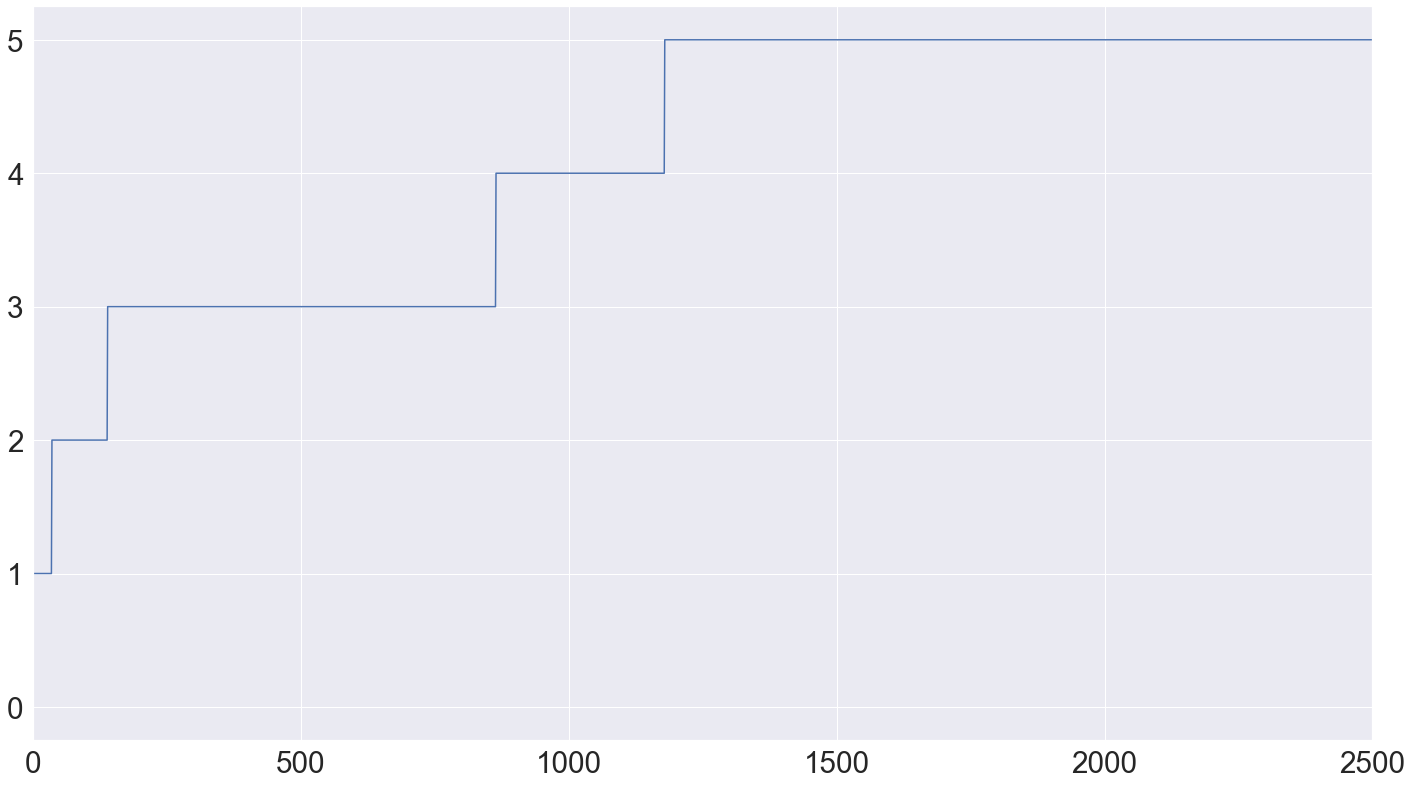

In [9]:
plt.plot(flight_phase_log)
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

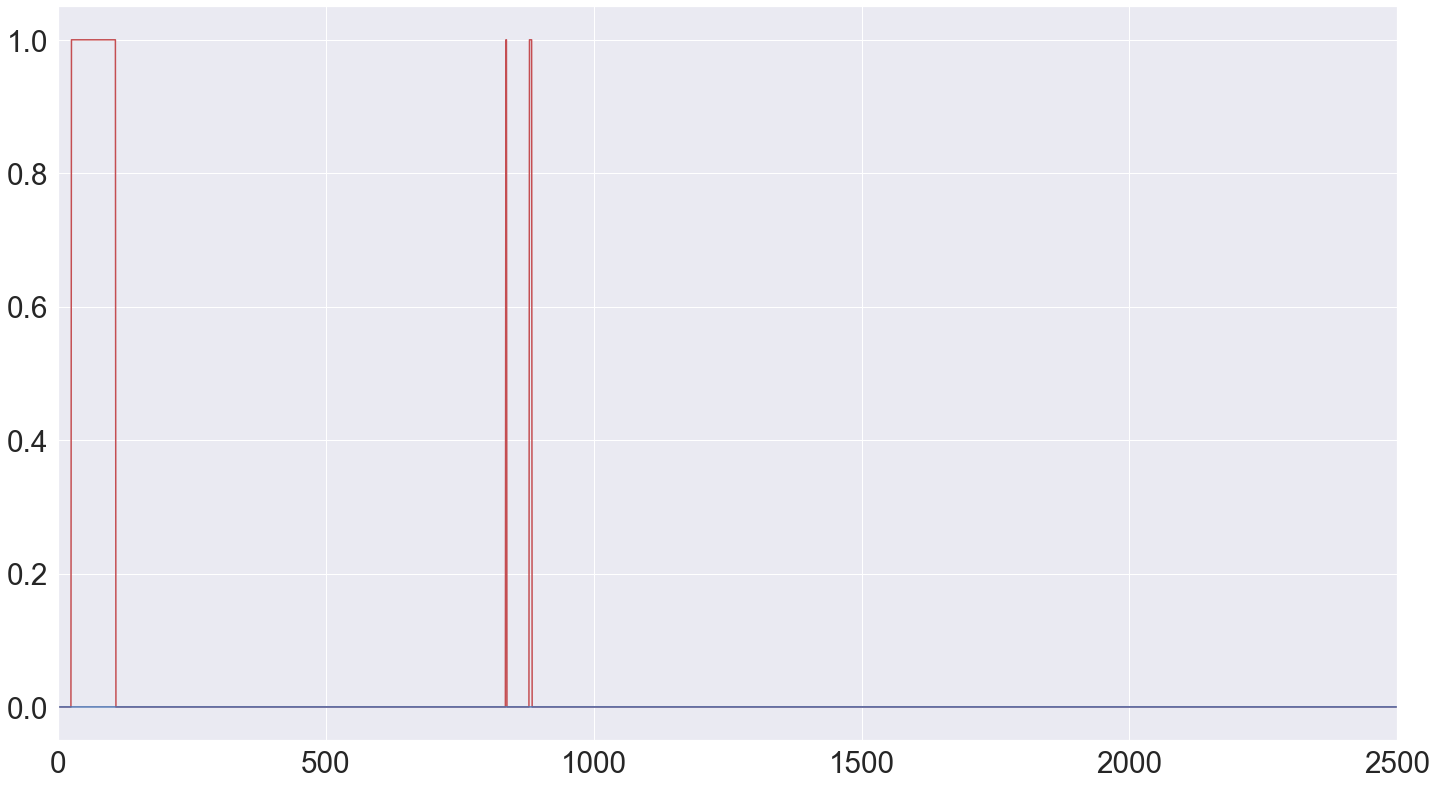

In [10]:
plt.plot(imu_elim_array, 'r')
plt.plot(baro_elim_array, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

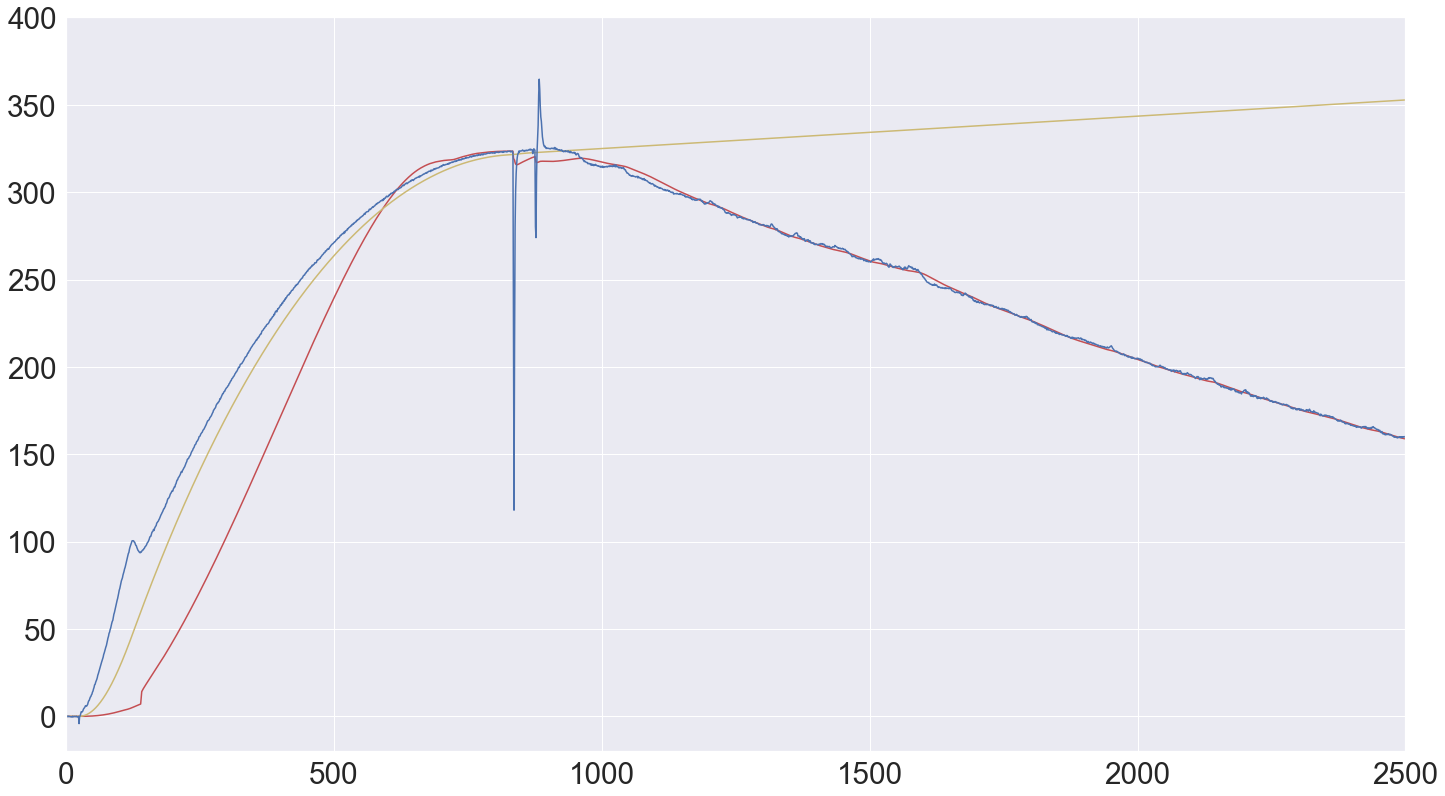

In [11]:
plt.plot(height, 'r')
plt.plot(height_acc, 'y')
plt.plot(agl, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
axes.set_ylim(plot_limits_y)
plt.show()

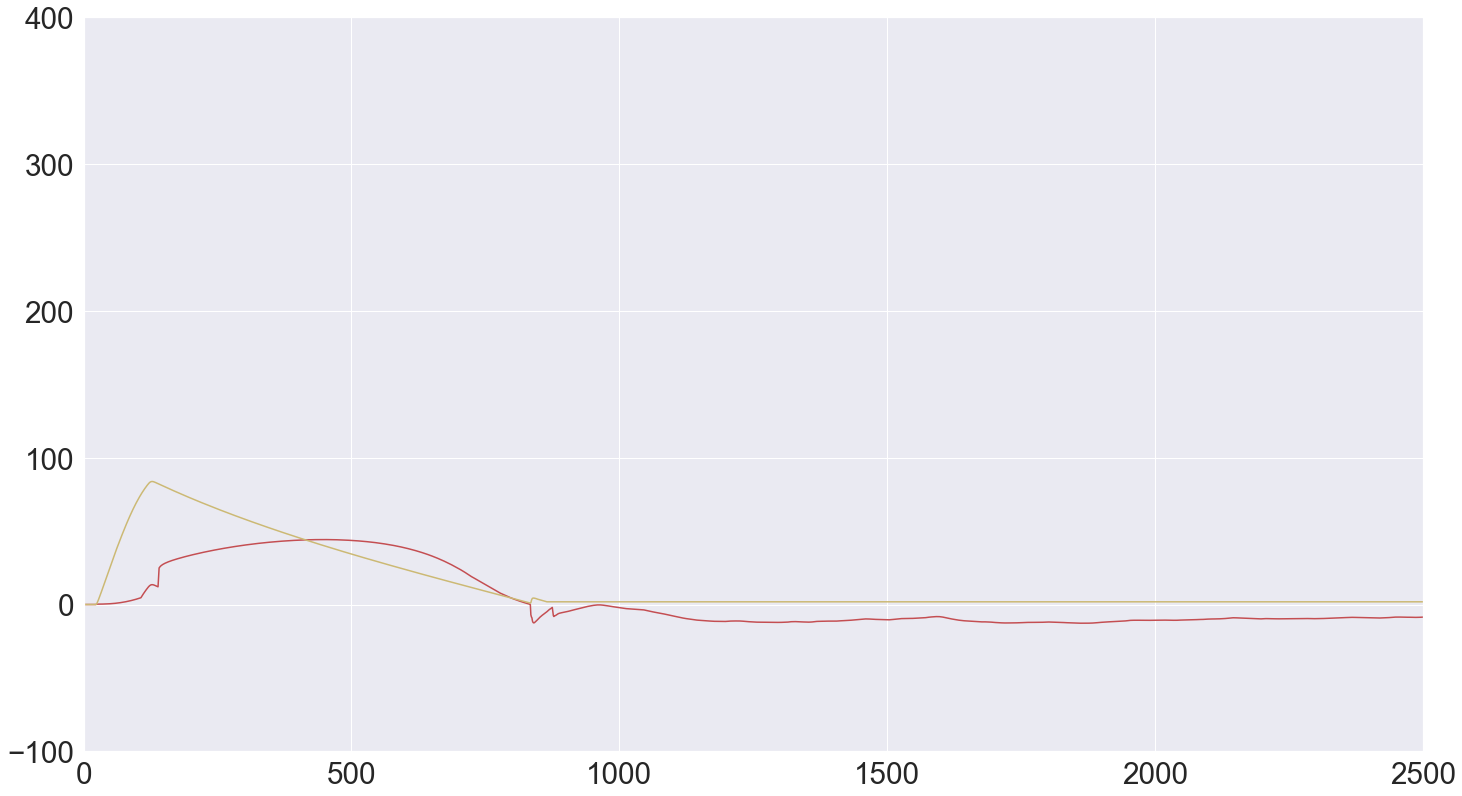

In [12]:
plt.plot(velocity, 'r')
plt.plot(velocity_acc, 'y')
#plt.plot(velocity_baro, 'b')
axes = plt.gca()
plot_limits_y = [-100, 400]
axes.set_xlim(plot_limits)
axes.set_ylim(plot_limits_y)
plt.show()

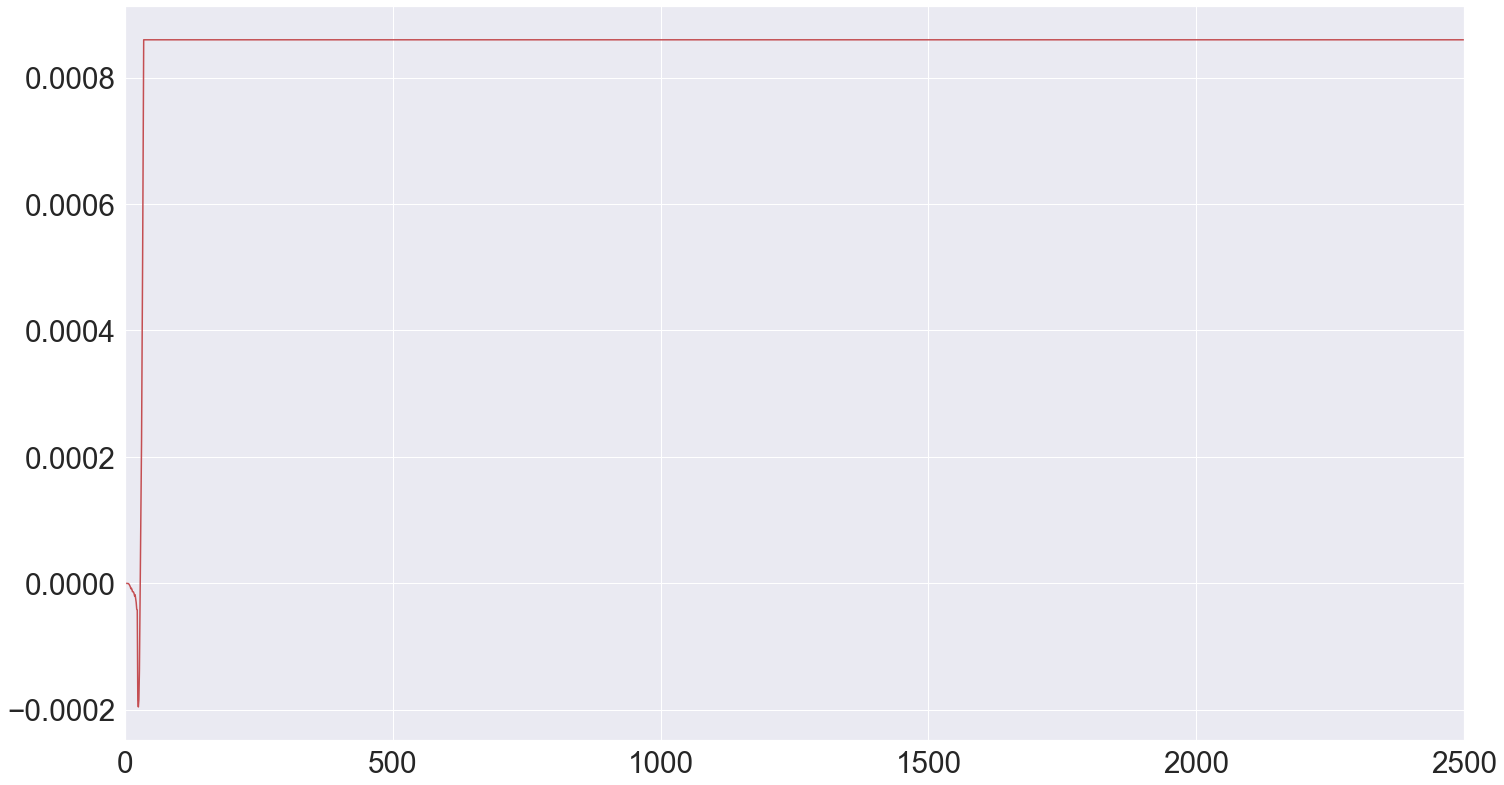

In [13]:
plt.plot(acc_offset, 'r')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

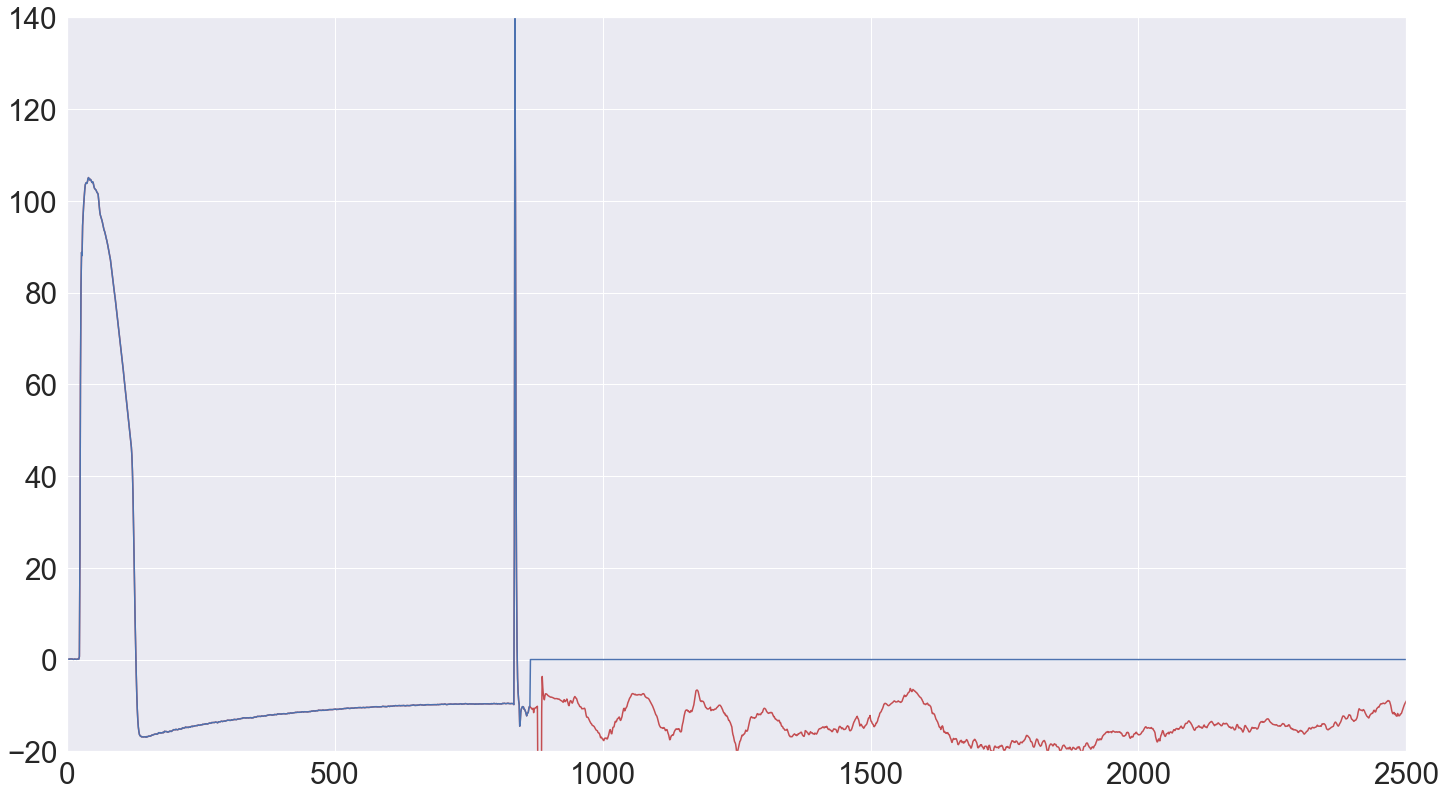

In [14]:
plt.plot(acc, 'r')
plt.plot(acc_filtered, 'b')
axes = plt.gca()
axes.set_xlim(plot_limits)
axes.set_ylim([-20, 140])
plt.show()

max(velocity_new)

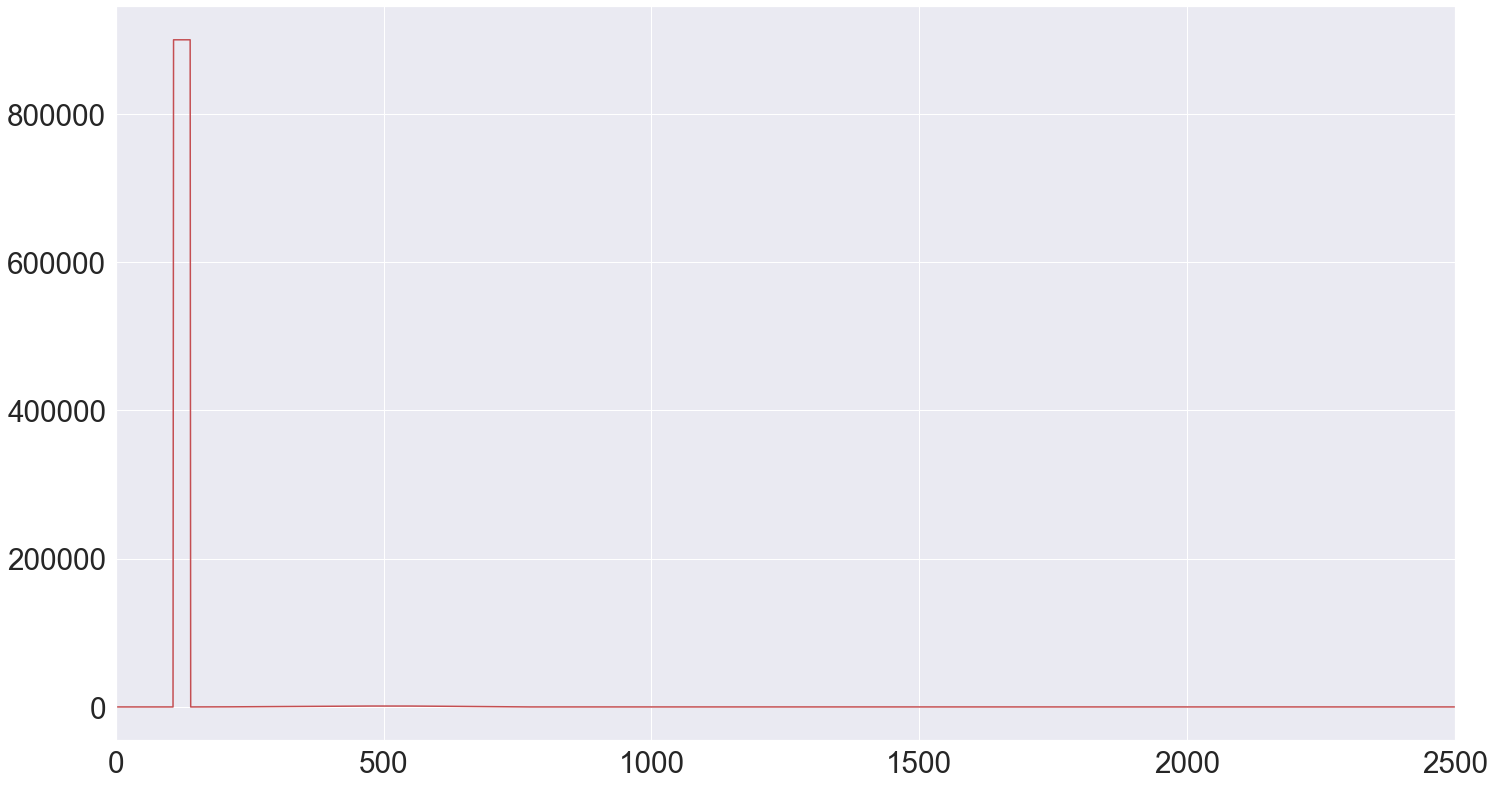

In [19]:
plt.plot(R_array, 'r')
axes = plt.gca()
axes.set_xlim(plot_limits)
plt.show()

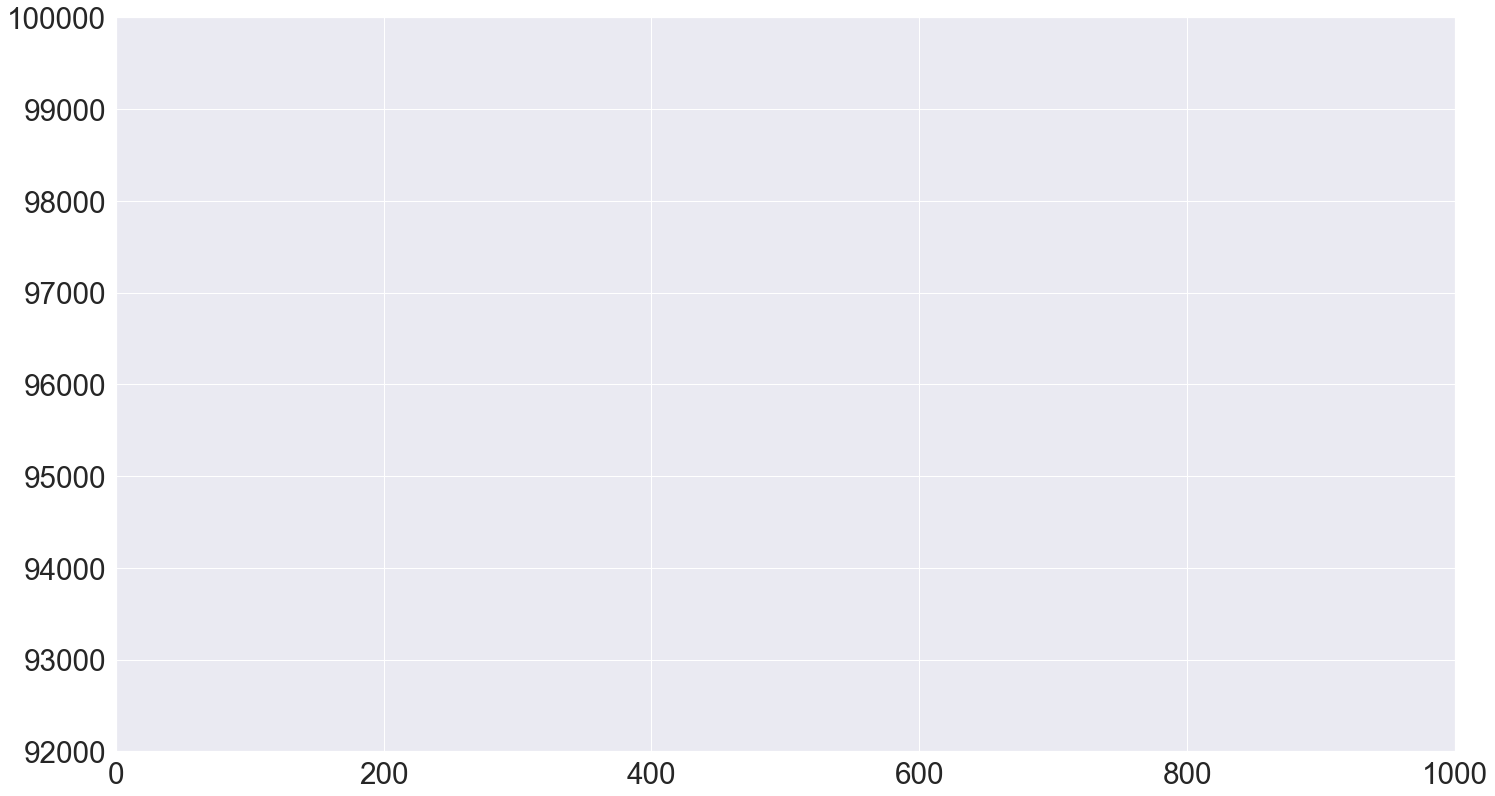

In [107]:
plt.plot(pressure)
axes = plt.gca()
axes.set_ylim([92000, 100000])
axes.set_xlim([0, 1000])
plt.show()